# Iris Dataset - Single Layer Neural Network with ReLU activation
#### Prepared by Hansel Wei for 4010 Deep Learning w/ Tensorflow

## Setup

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def reset_graph(seed=RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Function to Load Iris Data

In [3]:
def get_iris_data():
    # load iris data
    iris   = datasets.load_iris()
    data   = iris["data"]
    target = iris["target"]

    # Prepend the column of 1s for bias
    N, M  = data.shape
    all_X = np.ones((N, M + 1))
    all_X[:, 1:] = data

    # Convert into one-hot vectors (converts categorical data to integer data)
    num_labels = len(np.unique(target))
    
    # Return a 2-D array with ones on the diagonal and zeros elsewhere.
    all_Y = np.eye(num_labels)[target]  
    return train_test_split(all_X, all_Y, test_size=0.33, random_state=RANDOM_SEED)

# Perceptron

In [4]:
import os  # imports the os
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(random_state=42, max_iter=1000)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

Saving figure perceptron_iris_plot


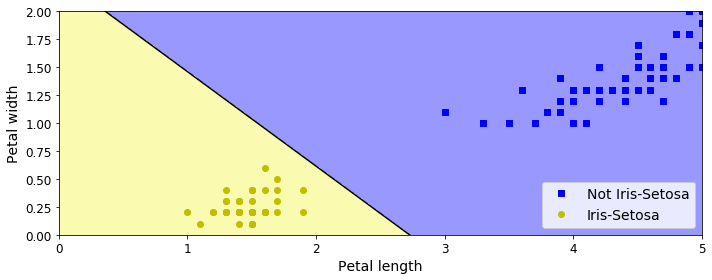

In [5]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    ) # creates the meshgrid
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-")
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Function to create a neuron layer
Unfortunately this has been deprecated due to getshape() not being a thing anymore so, moving on!

In [6]:
# def neuron_layer(X, n_neurons, name, activation=None):
#     with tf.name_scope(name):
#         # get the number of inputs by getting the input shape
#         n_inputs = int(tf.reshape(X.getshape()[1])
#         # getting size of second dimension
#         stdev = 2 / np.sqrt(n_inputs)
#         # 2D tensor connecting weights between each 
#         init = tf.truncated_normal((n_inputs, n_nerons))
#         # hold the weights (called the layer kernel)
#         W = tf.Variable(init, name="kernel")
#         # creates bias initalized to 0
#         b = tf.Variable(tf.zeros([n_neurons]), name="bias")
#         # weights of sums of the imputs plus the bias term for each and every neuron (Z = X * W + b) 
#         Z = tf.matmul(X, W) + b
        
#         if activation is not None:
#             return activation(Z)
#         else:
#             return Z

# Using dense() instead of neuron_layer()

In [7]:
# init ndarrays from data
train_X, test_X, train_y, test_y = get_iris_data()

# Layer's sizes
n_inputs = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
n_hidden1 = 256                # Number of hidden nodes
# n_hidden# able to create additonal layers here
# n_hidden2 = 100
n_outputs = train_y.shape[1]   # Number of outcomes (3 iris flowers)

In [8]:
reset_graph()

# Symbols
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# Create neuron layers
with tf.name_scope("dnn"):
#     hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
# hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
# logits = neuron_layer(hidden2, n_outputs, name="outputs")
# logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")
    print(logits)

Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)


In [9]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [10]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [11]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [12]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
predict = tf.argmax(logits, axis=1)

# Backward propagation
cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

# Train model

In [14]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(100):
        # Train with each example
        for i in range(len(train_X)):
            sess.run(updates, feed_dict={X: train_X[i: i + 1], y: train_y[i: i + 1]})

        train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: train_X, y: train_y}))
        test_accuracy  = np.mean(np.argmax(test_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: test_X, y: test_y}))

        print("Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
              % (epoch + 1, 100. * train_accuracy, 100. * test_accuracy))

sess.close()

Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Epoch = 2, train accuracy = 69.00%, test accuracy = 72.00%
Epoch = 3, train accuracy = 78.00%, test accuracy = 82.00%
Epoch = 4, train accuracy = 84.00%, test accuracy = 86.00%
Epoch = 5, train accuracy = 90.00%, test accuracy = 92.00%
Epoch = 6, train accuracy = 92.00%, test accuracy = 94.00%
Epoch = 7, train accuracy = 92.00%, test accuracy = 96.00%
Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Epoch = 9, train accuracy = 93.00%, test accuracy = 98.00%
Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Epoch = 11, train accuracy = 94.00%, test accuracy = 98.00%
Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Epoch = 17, train accuracy = 96.00%, test accurac

# Full Experiment

In [23]:
file=open("final_results.csv", "a")
file.write("Hidden Layers\nEpoch\ntrain accuracy\ntest accuracy")

def write_results(s):
    file=open("final_results.csv", "a")
    file.write(s + "\n")

# Experiment with layers 1 to 256
for hidden_layer in range(1,257):
    reset_graph()
    
    # init ndarrays from data
    train_X, test_X, train_y, test_y = get_iris_data()

    # Layer's sizes
    n_inputs = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
    n_hidden1 = hidden_layer       # Number of hidden nodes
    n_outputs = train_y.shape[1]   # Number of outcomes (3 iris flowers)

    # Symbols
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    y = tf.placeholder(tf.int32, shape=(None), name="y")
    
    # Create neuron layers
    with tf.name_scope("dnn"):
        hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
        logits = tf.layers.dense(hidden1, n_outputs, name="outputs")
        print(logits)
        sess = tf.Session()
        init = tf.global_variables_initializer()
        sess.run(init)
    
    # loss
    with tf.name_scope("loss"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")
    
    # train
    learning_rate = 0.01

    with tf.name_scope("train"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
    
    # evaluate
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    predict = tf.argmax(logits, axis=1)

    # Backward propagation
    cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
    updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

    for epoch in range(100):
            # Train with each example
            for i in range(len(train_X)):
                sess.run(updates, feed_dict={X: train_X[i: i + 1], y: train_y[i: i + 1]})

            train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                                     sess.run(predict, feed_dict={X: train_X, y: train_y}))
            test_accuracy  = np.mean(np.argmax(test_y, axis=1) ==
                                     sess.run(predict, feed_dict={X: test_X, y: test_y}))

            print("Hidden Layers = %d, Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
                  % (hidden_layer, epoch + 1, 100. * train_accuracy, 100. * test_accuracy))
            s = str("%d,%d,%.2f%%,%.2f%%"%(hidden_layer, epoch + 1, 100. * train_accuracy, 100. * test_accuracy) 
            write_results(s)
    sess.close()
    print("="*100)

SyntaxError: invalid syntax (<ipython-input-23-95660e6f5376>, line 72)